In [44]:
# IMPORTS
# import sys
# sys.path.insert(0, '../Analysis')
import helpers as h
import empatica_helpers as eh
import inquisit_helpers as ih
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

reload(h), reload(eh), reload(ih)

# GLOBAL SETTINGS
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('seaborn-v0_8-notebook') # plt.style.use('ggplot'); print(plt.style.available)
pd.set_option('display.max_columns', None)

sr = 32
wl = 24 # Window length in seconds

# FULL PIPELINE
# e_raw, _ = eh.load_empatica(data_folder='input/empatica/', useIBI=False, save=True, plotTrimmings=False, desired_sampling_rate=sr)
# i_raw = ih.load_inquisit(data_folder='input/inquisit/', save=True)
# ei_raw = h.combine_empatica_and_inquisit(e_raw, i_raw, save=True, sr=sr)
# ei_prep = h.clean_scale_filter(save=True, normalise=None, sr=sr, window_length=wl)
X, y, p = h.prepare_for_vae(sr=sr, wl=wl, filepath="output/ei_prep.csv", save=True, normalise=False) # Normalisation now happens later in the process. Normalise = False applies the standard scaler to the data.

X_train, X_val, X_test, y_train, y_val, y_test, p_train, p_val, p_test = h.prepare_train_val_test_sets(filenames=['output/dl_X_wl24_sr32.pkl', 'output/dl_y_wl24_sr32.pkl', 'output/dl_p_wl24_sr32.pkl'])

# BACK TO INPUTS FOR ML MODELS
# X_train_aggregates = h.prepare_for_ml(X_train)
# X_val_aggregates = h.prepare_for_ml(X_val)
# X_test_aggregates = h.prepare_for_ml(X_test)

/Users/koenraijer/Documents/00_Werk/Data_science/Thesis/Analysis/helpers.py:301: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


X shape: (1260, 768, 6)
y shape: (1260,)
p shape: (1260,)
Train size:  80.23809523809524
Val size:  8.333333333333332
Test size:  11.428571428571429
Size: : (1011, 768, 6)


## Evaluating statistical similarity between real and synthetic samples
- Options are: MANOVA and Wilks' Lambda. 
- Test multivariate normality using Mardia's tests.
- Test homogeneity of variances and covariances using Box's M test. 
- Independence of observations 
- If assumptions aren't met, we can use non-parametric tests like the multivariate analogue of the Mann-Whitney U test: the Kruskal-Wallis test by ranks. 

In [38]:
# Take the mean of each feature per sample
X_train_mean = np.mean(X_train, axis=1)

# Split along the decision class
X_train_0 = X_train_mean[y_train == 0]
X_train_1 = X_train_mean[y_train == 1]

# Split in half to create "real" and "synthetic" samples per decision class
X_train_0_synt = X_train_0[:len(X_train_0) // 2]
X_train_0_real = X_train_0[len(X_train_0) // 2:]

X_train_1_synt = X_train_1[:len(X_train_1) // 2]
X_train_1_real = X_train_1[len(X_train_1) // 2:]


HZResults(hz=9.414893040457386, pval=0.0, normal=False)
HZResults(hz=10.060321627047447, pval=0.0, normal=False)
HZResults(hz=5.1179577013492334, pval=2.604259332841944e-262, normal=False)
HZResults(hz=4.6774254623184, pval=3.3950872525934126e-236, normal=False)


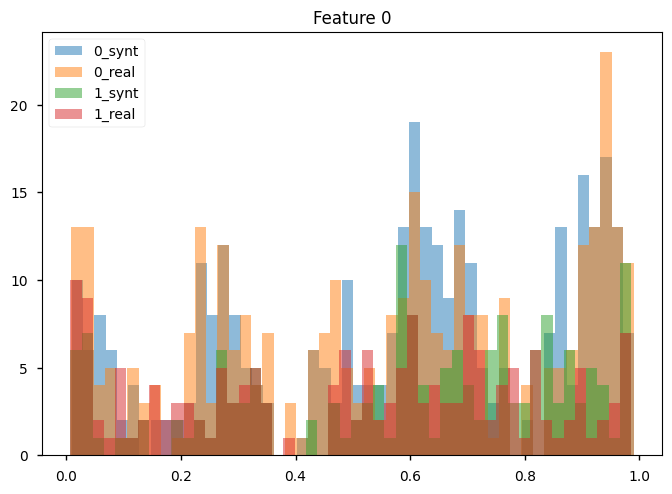

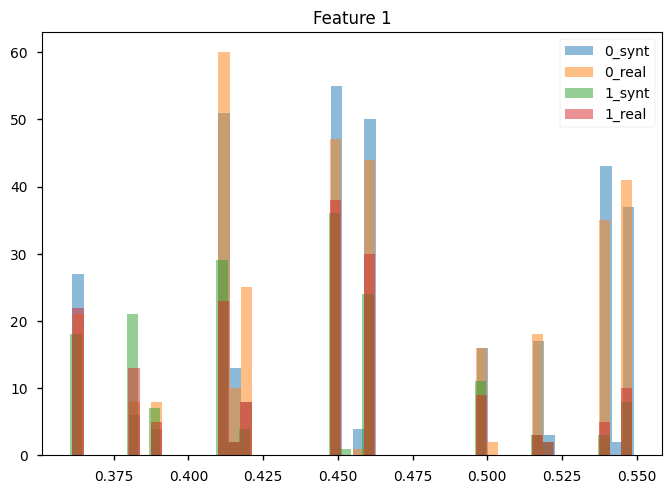

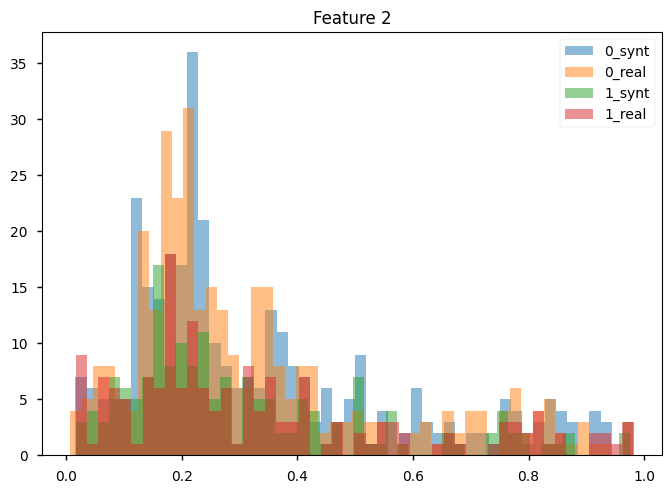

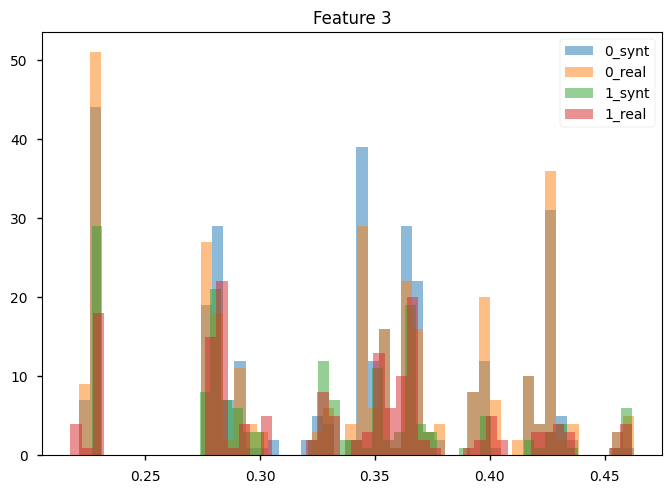

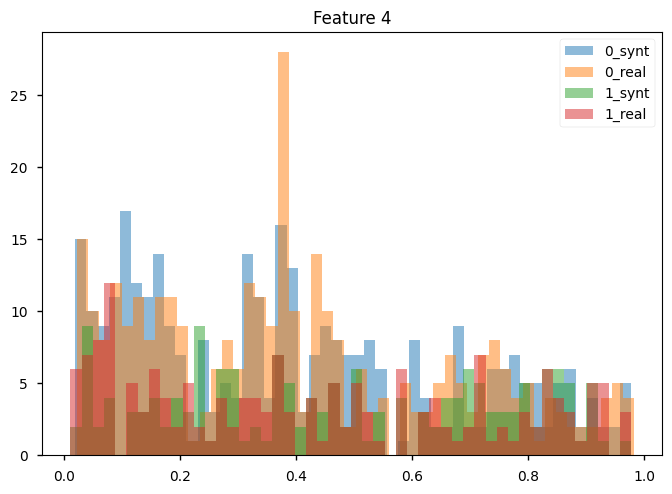

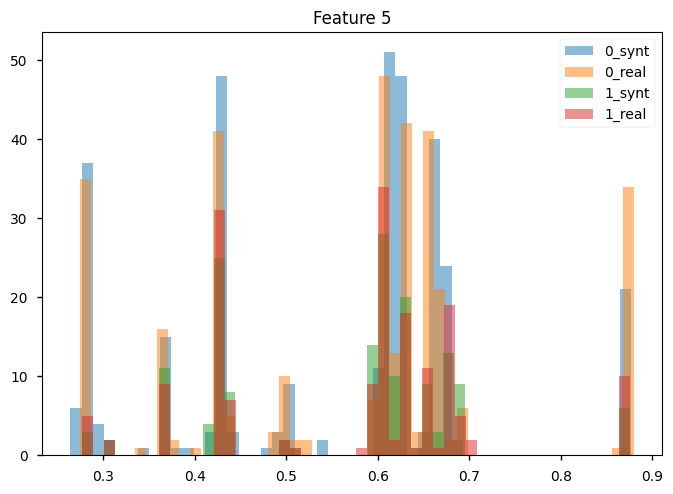

In [40]:
from pingouin import multivariate_normality

print(multivariate_normality(X_train_0_synt, alpha=0.05))
print(multivariate_normality(X_train_0_real, alpha=0.05))
print(multivariate_normality(X_train_1_synt, alpha=0.05))
print(multivariate_normality(X_train_1_real, alpha=0.05))

# Plot the distributions per feature
for i in range(X_train_0_synt.shape[1]):
    plt.figure()
    plt.hist(X_train_0_synt[:, i], bins=50, alpha=0.5, label='0_synt')
    plt.hist(X_train_0_real[:, i], bins=50, alpha=0.5, label='0_real')
    plt.hist(X_train_1_synt[:, i], bins=50, alpha=0.5, label='1_synt')
    plt.hist(X_train_1_real[:, i], bins=50, alpha=0.5, label='1_real')
    plt.legend()
    plt.title(f'Feature {i}')
    plt.show()

## Non-parametric multivariate significance testing
- Multivariate Kruskal-Wallis test has no known implementation in Python
- It is possible to do a univariate Kruskal-Wallis with post-hoc [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)

In [41]:
from statsmodels.stats.multitest import multipletests
from scipy.stats.mstats import kruskalwallis

# Perform Kruskal-Wallis test for each feature per decision class
p_values_0 = []
H_values_0 = []

p_values_1 = []
H_values_1 = []

for i in range(X_train_0_synt.shape[1]):
    H, p = kruskalwallis(X_train_0_synt[:, i], X_train_0_real[:, i])
    p_values_0.append(p)
    H_values_0.append(H)

    H, p = kruskalwallis(X_train_1_synt[:, i], X_train_1_real[:, i])
    p_values_1.append(p)
    H_values_1.append(H)

# Correct for multiple comparisons
p_values_0_corr = multipletests(p_values_0, method='fdr_bh')[1]
p_values_1_corr = multipletests(p_values_1, method='fdr_bh')[1]

print("Class 0")
print("Original: ", p_values_0)
print("Corrected: ", p_values_0_corr)

print("Class 1:")
print("Original: ", p_values_1)
print("Corrected: ", p_values_1_corr)

Class 0
Original:  [0.5063849172438648, 0.3173612646442844, 0.5534855876901706, 0.5612268223129031, 0.7140544903164553, 0.03658181336579292]
Corrected:  [0.67347219 0.67347219 0.67347219 0.67347219 0.71405449 0.21949088]
Class 1:
Original:  [0.0018355992283120373, 0.3734561035041014, 0.4140049889874978, 0.34983556865496235, 0.11423926715089543, 0.615604228923305]
Corrected:  [0.0110136  0.49680599 0.49680599 0.49680599 0.3427178  0.61560423]


## t-SNE (t-Distributed Stochastic Neighbor Embedding) 

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.


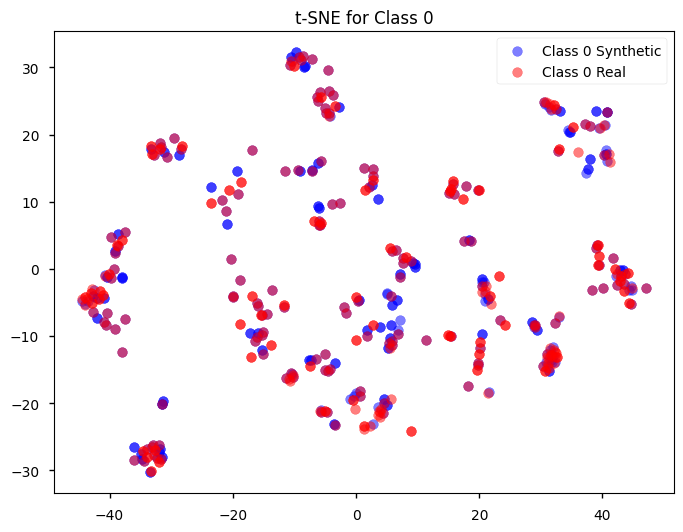

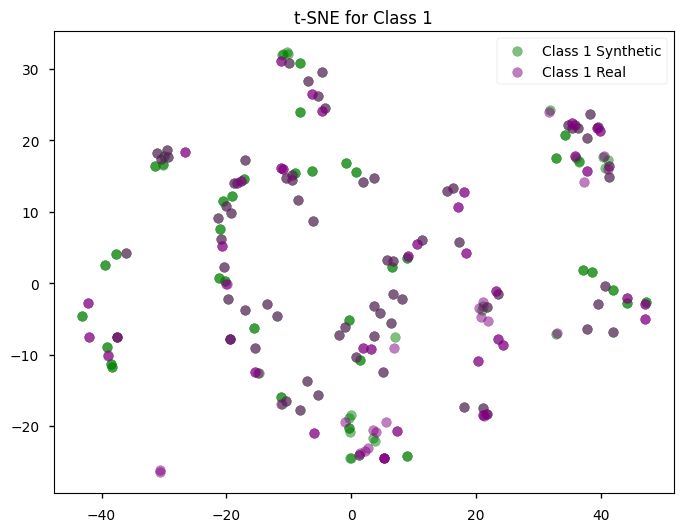

In [47]:
from sklearn.manifold import TSNE

X_all = np.concatenate([X_train_0_synt, X_train_0_real, X_train_1_synt, X_train_1_real])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_all)

# Plot the first two t-SNE components for class 0
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:len(X_train_0_synt), 0], X_tsne[:len(X_train_0_synt), 1], color='blue', alpha=0.5, label='Class 0 Synthetic')
plt.scatter(X_tsne[len(X_train_0_synt):len(X_train_0_synt)+len(X_train_0_real), 0], X_tsne[len(X_train_0_synt):len(X_train_0_synt)+len(X_train_0_real), 1], color='red', alpha=0.5, label='Class 0 Real')
plt.legend()
plt.title('t-SNE for Class 0')
plt.show()

# Plot the first two t-SNE components for class 1
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[len(X_train_0_synt)+len(X_train_0_real):len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt), 0], X_tsne[len(X_train_0_synt)+len(X_train_0_real):len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt), 1], color='green', alpha=0.5, label='Class 1 Synthetic')
plt.scatter(X_tsne[len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt):, 0], X_tsne[len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt):, 1], color='purple', alpha=0.5, label='Class 1 Real')
plt.legend()
plt.title('t-SNE for Class 1')
plt.show()

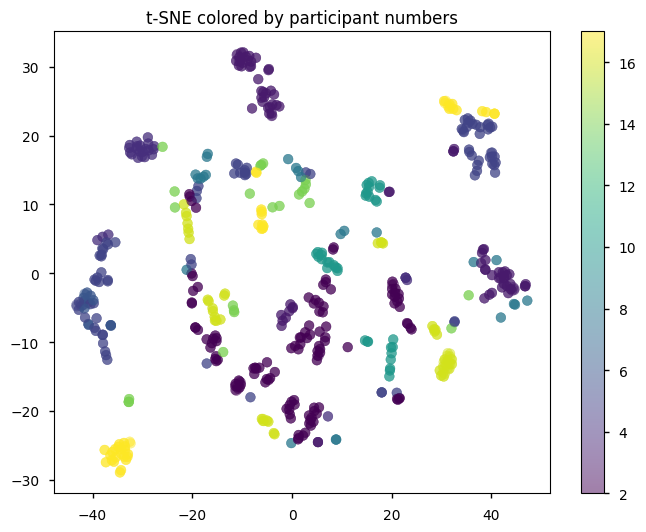

In [46]:
from sklearn.manifold import TSNE

X_train.shape # (n_samples, n_features)

# Perform t-SNE on X_train_mean
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_mean)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Use p_train for coloring
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=p_train, alpha=0.5)

# Add a color bar
plt.colorbar(scatter)

plt.title('t-SNE colored by participant numbers')
plt.show()

In [45]:
import pandas as pd
import numpy as np

X_mean = np.mean(X, axis=1)

df = pd.DataFrame(X_mean)
df['participant'] = p

# Calculate mean and std per participant per feature
mean_per_participant = df.groupby('participant').mean()
std_per_participant = df.groupby('participant').std()

# Print mean and std per participant per feature
print("Mean per participant per feature:")
print(mean_per_participant)
print("\nStd per participant per feature:")
print(std_per_participant)

Mean per participant per feature:
                0     1     2     3     4     5
participant                                    
1.00         0.50 -0.00 -0.43  0.01  1.13 -0.03
2.00        -0.18  0.00  0.16 -0.00 -0.41  0.01
3.00         0.00  0.00 -0.00 -0.00  0.00 -0.00
4.00         0.00  0.00  0.00  0.00 -0.00 -0.00
5.00        -0.12 -0.00  0.04  0.01  0.11 -0.00
6.00         0.89  0.00 -0.32 -0.07 -0.80  0.00
7.00         0.00 -0.00 -0.00 -0.00 -0.00 -0.00
8.00        -0.00  0.00 -0.00 -0.00  0.00 -0.00
10.00        0.00  0.00  0.00 -0.00 -0.00 -0.00
13.00       -0.79  0.00  0.49 -0.01 -1.53 -0.01
14.00       -0.18 -0.00  0.19  0.00  0.25  0.00
15.00        0.36  0.00 -0.31 -0.00  0.08  0.00
16.00       -0.00  0.00 -0.00 -0.00 -0.00 -0.00
17.00        0.00  0.00  0.00 -0.00  0.00 -0.00

Std per participant per feature:
               0    1    2    3    4    5
participant                              
1.00        0.70 0.01 0.37 0.09 0.68 0.21
2.00        1.03 0.01 1.09 0.15 0.74 0